# Preliminaries (takes around 30 mins)

In [2]:
!pip install  libharfbuzz-dev libfribidi-dev libtiff5-dev libgsl-dev
!pip cdt ges rpy2==3.5.1

ERROR: Could not find a version that satisfies the requirement libharfbuzz-dev (from versions: none)
ERROR: No matching distribution found for libharfbuzz-dev


In [1]:
%load_ext rpy2.ipython

In [2]:
%%R
update.packages(ask=FALSE)
install.packages("BiocManager")
BiocManager::install(c("graph", "RBGL"))
install.packages(c("pcalg", "kpcalg", "devtools"))
devtools::install_github("Diviyan-Kalainathan/RCIT")

--- Please select a CRAN mirror for use in this session ---
Secure CRAN mirrors 

 1: 0-Cloud [https]
 2: Australia (Canberra) [https]
 3: Australia (Melbourne 1) [https]
 4: Australia (Melbourne 2) [https]
 5: Austria (Wien 1) [https]
 6: Belgium (Brussels) [https]
 7: Brazil (PR) [https]
 8: Brazil (SP 1) [https]
 9: Brazil (SP 2) [https]
10: Bulgaria [https]
11: Canada (MB) [https]
12: Canada (ON 1) [https]
13: Canada (ON 2) [https]
14: Chile (Santiago) [https]
15: China (Beijing 2) [https]
16: China (Beijing 3) [https]
17: China (Hefei) [https]
18: China (Hong Kong) [https]
19: China (Guangzhou) [https]
20: China (Jinan) [https]
21: China (Nanjing) [https]
22: China (Shanghai 2) [https]
23: China (Shenzhen) [https]
24: China (Wuhan) [https]
25: Colombia (Cali) [https]
26: Costa Rica [https]
27: Cyprus [https]
28: Czech Republic [https]
29: Denmark [https]
30: East Asia [https]
31: Ecuador (Cuenca) [https]
32: France (Lyon 1) [https]
33: France (Lyon 2) [https]
34: France (Marseille

* installing *source* package ‘RCIT’ ...
** using staged installation
** R
** byte-compile and prepare package for lazy loading
** help
*** installing help indices
** building package indices
** testing if installed package can be loaded from temporary location
** testing if installed package can be loaded from final location
** testing if installed package keeps a record of temporary installation path
* DONE (RCIT)


trying URL 'https://ftp.osuosl.org/pub/cran/bin/macosx/big-sur-arm64/contrib/4.4/BiocManager_1.30.25.tgz'
Content type 'application/x-gzip' length 503561 bytes (491 KB)
downloaded 491 KB

'getOption("repos")' replaces Bioconductor standard repositories, see
'help("repositories", package = "BiocManager")' for details.
Replacement repositories:
    CRAN: https://ftp.osuosl.org/pub/cran
Bioconductor version 3.20 (BiocManager 1.30.25), R 4.4.2 (2024-10-31)
Installing package(s) 'BiocVersion', 'graph', 'RBGL'
also installing the dependencies ‘BiocGenerics’, ‘BH’

trying URL 'https://bioconductor.org/packages/3.20/bioc/bin/macosx/big-sur-arm64/contrib/4.4/BiocGenerics_0.52.0.tgz'
Content type 'application/x-gzip' length 628584 bytes (613 KB)
downloaded 613 KB

trying URL 'https://ftp.osuosl.org/pub/cran/bin/macosx/big-sur-arm64/contrib/4.4/BH_1.84.0-0.tgz'
Content type 'application/x-gzip' length 13575731 bytes (12.9 MB)
downloaded 12.9 MB

trying URL 'https://bioconductor.org/packages/3.20/

# GES algorithm

Greedy Equivalence Search (GES) (https://www.jmlr.org/papers/volume3/chickering02b/chickering02b.pdf) is a score-based causal discovery algorithm. We consider the score $S(G,D)$ of a graph $G$ given the data $D$ to be computed according to the Bayesian Information Criterion (BIC) score. The algorithm constists of three steps:
1. Start with an empty CPDAG representing a MEC
2. Forward phase: add edges one by one until local maxima in BIC
3. Backward phase: remove edges one by one until local maxima in BIC

The resulting intermediate models during the forward and backward phases are mapped to their corresponding Markov equivalence classes

In [3]:
# import necessary packages
import cdt
import ges
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd

np.random.seed(0)

No GPU automatically detected. Setting SETTINGS.GPU to 0, and SETTINGS.NJOBS to cpu_count.


For our experiment, we use synthetic data generated by the same SCM that we used in Tutorial 5, shown below.
$$
\begin{aligned}
X_1 &\leftarrow \epsilon_1 & \epsilon_1 &\sim \mathcal N(0,1)\\
X_2 &\leftarrow \epsilon_2 & \epsilon_2 &\sim \mathcal N(0,1)\\
X_3 &\leftarrow X_1 + X_2 + \epsilon_3 & \epsilon_3 &\sim \mathcal N(0,0.7)\\
X_4 &\leftarrow 2 X_1 + \epsilon_4 & \epsilon_4 &\sim \mathcal N(0,1.5)\\
X_5 &\leftarrow 3 X_3 + \epsilon_5 & \epsilon_5 &\sim \mathcal N(0,1)\\
\end{aligned}
$$

In [3]:
# n_samples=10000

# eps1 = np.random.normal(0, 1, n_samples)
# eps2 = np.random.normal(0, 2, n_samples)
# eps3 = np.random.normal(0, 0.7, n_samples)
# eps4 = np.random.normal(0, 1.5, n_samples)
# eps5 = np.random.normal(0, 1, n_samples)

# x1 = eps1
# x2 = eps2
# x3 = x1 + x2 + eps3
# x4 = 2 * x1 + eps4
# x5 = 3 * x3 + eps5

# df = pd.DataFrame({'x1': x1,'x2': x2,'x3': x3,'x4': x4,'x5': x5})

In [4]:
df = pd.read_csv('lalonde_data.csv')

In [8]:
df_withoutid = df[['treat','age','educ','black','hispan','married','nodegree','re74','re75','re78']]
list(df_withoutid.columns)

['treat',
 'age',
 'educ',
 'black',
 'hispan',
 'married',
 'nodegree',
 're74',
 're75',
 're78']

As a reference, we can manually draw the true causal graph according to the SCM.

In [9]:
#nodes = ['x1', 'x2', 'x3', 'x4', 'x5']
nodes = list(df_withoutid.columns)
# pos = {'x1': (1, 1), 'x2': (-1, 1), 'x3': (0, 0.5), 'x4': (1, -1), 'x5': (-1, -1)}

# true_graph = nx.DiGraph([('x1', 'x3'), ('x2', 'x3'), ('x1', 'x4'), ('x3', 'x5')])
# nx.draw(true_graph, with_labels=True, node_size=500, node_color='w', edgecolors ='black', pos=pos)

### Step-by-step
Before simply running GES with a simple function call on our data, let's take a closer look at the learning process. We first select our score function to be the Gaussian BIC score (this is the only score function implemented in the `ges` package) and create the initial empty CPDAG, which will be represented by adjacency matrices throughout the algorithm. Following this, we run the forward phase and then the backward phase, each until we cannot add or remove an edge that increases the score of the candidate CPDAG. Each time an edge is added or removed, the resulting DAG and its corresponding score change is computed. If the score change is positive, then we update the CPDAG according to the found DAG, and continue the phase.

In [10]:
# Containers to hold data from intermediate steps
inter_adjs = []
inter_scores = []
inter_phases = []

# Initialization
score_class = ges.scores.gauss_obs_l0_pen.GaussObsL0Pen(df.to_numpy()) # initalize the Gaussian BIC score (with numpy array)
cpdag = np.zeros((len(nodes), len(nodes))) # Initialize empty CPDAG as adjacency matrix
score = 0

# Run phases
for phase in [ges.forward_step, ges.backward_step]: # Run forward then backward phase
    print('GES {} phase start'.format(phase.__name__))
    while True: # Continue while we can increase the score in the current phase
        score_change, dag = phase(cpdag, score_class, 2) # Compute best possible score change and corresponding DAG
        if score_change > 0: # The score can be increased
            cpdag = ges.utils.pdag_to_cpdag(dag) # Get CPDAG of DAG
            score += score_change # Update total score

            # Save intermediate state
            inter_adjs.append(cpdag)
            inter_scores.append(score)
            inter_phases.append(phase.__name__)

            # Print intermediate state
            print('New score: {0:.4f}'.format(score))
            [print(row) for row in cpdag]
            print()
        else: # The score cannot be increased thus we end the phase
            break

TypeError: unsupported operand type(s) for /: 'str' and 'int'

The output above shows that at each step in each phase, a set of candidate edges that we can insert/delete is considered, and their corresponding score changes of the insertion or deletion is calculated. The algorithm selects the best valid operation and returns the score change, and the corresponding candidate DAG. As we can see, the algorithm can add four edges to the CPDAG, but any fifth edge would result in a decreased score. After this, the algorithm cannot delete any edges for the same reason.

We can also visualize the whole process by drawing the intermediate CPDAG at each step. We can see how the number of edges grows during forward steps, and how the algorithm transitions between CPDAGs defining different v-structures (from step 2 to 3).

In [7]:
fig, axs = plt.subplots(1, len(inter_adjs), figsize=(25, 5))
for ax, adj, score, phase in zip(axs, inter_adjs, inter_scores, inter_phases):
    G = nx.relabel_nodes(nx.DiGraph(adj), {idx: i for idx, i in enumerate(df.columns)})
    colors = ['red'  if (y,x) in G.edges() else 'black' for (x,y) in G.edges()]
    nx.draw_networkx(G, ax=ax, with_labels=True, node_size=500, node_color='w', edgecolors ='black', pos=pos,
                     edge_color=colors)
    ax.set_title(phase + ' with score of {0:.3f}'.format(score))
plt.show()

ValueError: Number of columns must be a positive integer, not 0

<Figure size 2500x500 with 0 Axes>

### End-to-end
If we only care about the end result, then we can simply call the `fit_bic` function ([reference](https://github.com/juangamella/ges#using-the-gaussian-bic-score-gesfit_bic)). This includes a "turning phase" (https://www.jmlr.org/papers/volume13/hauser12a/hauser12a.pdf) that improves the GES algorithm, which we did not cover in the class or this tutorial. The parameters of this function allow you to turn the turning phase off, as well as define the initial CPDAG and control whether you wish to run phases in a loop. However, the standard parameters should work best for most cases.

In [ ]:
result, score = ges.fit_bic(df.to_numpy()) # The result is a CPDAG represented by an adjacency matrix
ges_graph = nx.relabel_nodes(nx.DiGraph(result), {idx: i for idx, i in enumerate(df.columns)})
colors = ['red'  if (y,x) in ges_graph.edges() else 'black' for (x,y) in ges_graph.edges()]
nx.draw(ges_graph, with_labels=True, node_size=500, node_color='w', edgecolors ='black', pos=pos, edge_color=colors)

You can also use the GES wrapper from the `cdt` package as shown below ([reference](https://fentechsolutions.github.io/CausalDiscoveryToolbox/html/causality.html?highlight=ges#ges)).

In [ ]:
cdt_gres_graph = cdt.causality.graph.GES(score='obs').predict(df)
colors = ['red'  if (y,x) in cdt_gres_graph.edges() else 'black' for (x,y) in cdt_gres_graph.edges()]
nx.draw(cdt_gres_graph, with_labels=True, node_size=500, node_color='w', edgecolors ='black', pos=pos, edge_color=colors)

Finally, you can also use GES from DoWhy on your own machine, but not in Colab
```py
import dowhy.graph_learners.ges as dowhy_ges
learner = dowhy_ges.GES(df, 'ges') # Notice that we don't pass df.to_numpy()
learner.learn_graph()
dowhy_ges_graph = nx.relabel_nodes(nx.DiGraph(learner._adjacency_matrix), {idx: i for idx, i in enumerate(df.columns)})
colors = ['red'  if (y,x) in dowhy_ges_graph.edges() else 'black' for (x,y) in dowhy_ges_graph.edges()]
nx.draw(dowhy_ges_graph, with_labels=True, node_size=500, node_color='w', edgecolors ='black', pos=pos, edge_color=colors)
```

# PC algorithm

In case you couldn't run the PC algorithm on your own machine, you can also do that in this notebook.

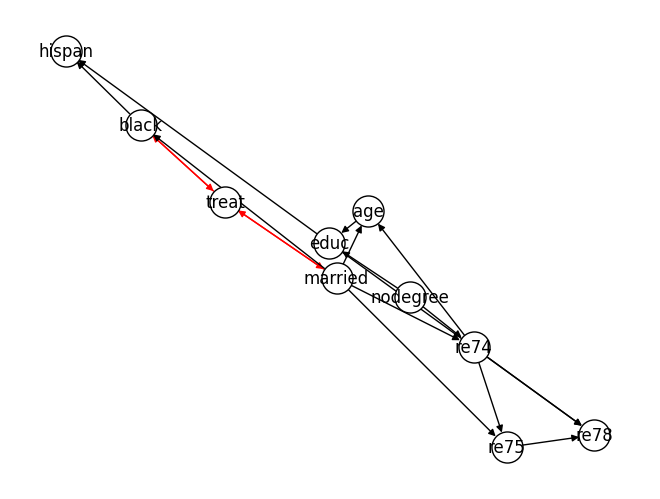

In [17]:
pc = cdt.causality.graph.PC(CItest="gaussian", alpha=0.05)
graph = pc.create_graph_from_data(df_withoutid)
#pos = {'x2': (-1, 1), 'x1': (1, 1), 'x3': (0, 0.5), 'x4': (1, -1), 'x5': (-1, -1), }
colors = ['red'  if (y,x) in graph.edges() else 'black' for (x,y) in graph.edges()]
nx.layout.shell_layout(graph)
nx.draw(graph, with_labels=True, node_size=500, node_color='w', edgecolors ='black', edge_color=colors)